In [1]:
#| default_exp datasets
%load_ext autoreload
%autoreload 2

In [2]:
#| include: false
from nbdev.showdoc import *

In [3]:
#| export 
import os
import pandas as pd, numpy as np
import phate
from sklearn import datasets

import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl

In [4]:
#| export
def construct_diamond(
    points_per_petal:int=200,
    petal_width:float=0.25,
    direction:str='y'
):
    '''
    Arguments:
    ----------
        points_per_petal (int). Defaults to `200`. Number of points per petal.
        petal_width (float): Defaults to `0.25`. How narrow the diamonds are.
        direction (str): Defaults to 'y'. Options `'y'` or `'x'`. Whether to make vertical
            or horizontal diamonds.
    Returns:
    ---------
        points (numpy.ndarray): the 2d array of points. 
    '''
    n_side = int(points_per_petal/2)
    axis_1 = np.concatenate((
                np.linspace(0, petal_width, int(n_side/2)), 
                np.linspace(petal_width, 0, int(n_side/2))
            ))
    axis_2 = np.linspace(0, 1, n_side)
    axes = (axis_1, axis_2) if direction == 'y' else (axis_2, axis_1)
    points = np.vstack(axes).T
    points = np.vstack((points, -1*points))
    points = np.vstack((points, np.vstack((points[:, 0], -1*points[:, 1])).T))
    return points

def make_diamonds(
    points_per_petal:int=200,
    petal_width:float=0.25,
    colors:int=5,
    scale_factor:float=30,
    use_gaussian:bool=True   
):
    '''
    Arguments:
    ----------
        points_per_petal (int). Defaults to `200`. Number of points per petal.
        petal_width (float): Defaults to `0.25`. How narrow the diamonds are.
        colors (int): Defaults to `5`. The number of timesteps (colors) to produce.
        scale_factor (float): Defaults to `30`. How much to scale the noise by 
            (larger values make samller noise).
        use_gaussian (bool): Defaults to `True`. Whether to use random or gaussian noise.
    Returns:
    ---------
        df (pandas.DataFrame): DataFrame with columns `samples`, `x`, `y`, where `samples`
            are the time index (corresponds to colors) 
    '''    
    upper = construct_diamond(points_per_petal, petal_width, 'y')
    lower = construct_diamond(points_per_petal, petal_width, 'x')
    data = np.vstack((upper, lower)) 
    
    noise_fn = np.random.randn if use_gaussian else np.random.rand
    noise = noise_fn(*data.shape) / scale_factor
    data = data + noise
    df = pd.DataFrame(data, columns=['d1', 'd2'])
    
    c_values = np.linspace(colors, 1, colors)
    c_thresholds = np.linspace(1, 0+1/(colors+1), colors)
    df.insert(0, 'samples', colors)
    df['samples'] = colors 
    for value, threshold in zip(c_values, c_thresholds):
        index = ((np.abs(df.d1) <= threshold) & (np.abs(df.d2) <= threshold))
        df.loc[index, 'samples'] = value
    df.set_index('samples')
    return df

<Axes: xlabel='d1', ylabel='d2'>

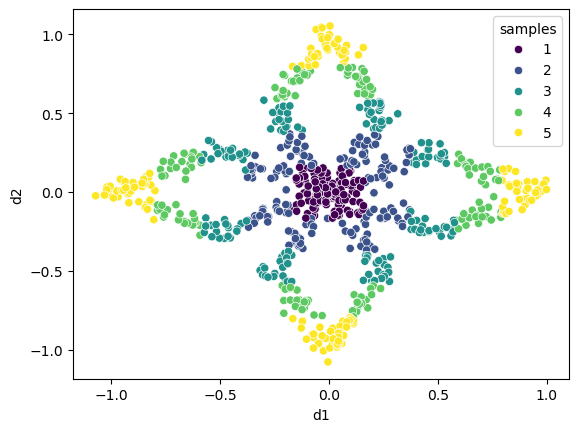

In [5]:
df = make_diamonds(200, 0.25, 5)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis')

In [6]:
#| export
def make_swiss_roll(n_points=1500):
    '''
    Arguments:
    ----------
        n_points (int): Default to `1500`. 

    Returns:
    ---------
        df (pandas.DataFrame): DataFrame with columns `samples`, `d1`, `d2`, `d3`, 
            where `samples` are the time index (corresponds to colors) 
    '''  
    X, color = datasets.make_swiss_roll(n_samples=n_points)
    df = pd.DataFrame(np.hstack((np.round(color).reshape(-1, 1), X)), columns='samples d1 d2 d3'.split())
    df.samples -= np.min(df.samples)
    return df

In [7]:
#| export
def make_tree():
    '''
    Arguments:
    ----------
        n_points (int): Default to `1500`. 
        
    Returns:
    ---------
        df (pandas.DataFrame): DataFrame with columns `samples`, `d1`, `d2`, `d3`, 
            `d4`, `d5` where `samples` are the time index (corresponds to colors) 
    '''  
    tree, branches = phate.tree.gen_dla(
        n_dim = 200, n_branch = 10, branch_length = 300, 
        rand_multiplier = 2, seed=37, sigma = 5
    )
    phate_operator = phate.PHATE(n_components=5, n_jobs=-1)
    tree_phate = phate_operator.fit_transform(tree)
    df = pd.DataFrame(np.hstack((branches.reshape(-1, 1), tree_phate)), columns='samples d1 d2 d3 d4 d5'.split())
    return df

In [8]:
#| export
from MIOFlow.constants import WORM_FILE
def make_worm_data():
    data = np.load(WORM_FILE)
    sample_labels = data['sample_labels']
    embedding = data['embedding']
    df = pd.concat([
            pd.DataFrame(sample_labels, columns=['samples']), 
            pd.DataFrame(embedding, columns=list(map(lambda e: f'd{e}', '12345')))
        ], axis=1,
    )
    df.set_index('samples')
    return df

In [9]:
#| export 
from MIOFlow.constants import EB_BODIES_FILE,EB_BODIES_PSEUDO_4,EB_BODIES_PSEUDO_6,EB_BODIES_PSEUDO_25,EB_BODIES_PSEUDO_82

def make_eb_data(phate=False, phate_dims=5,n_sample='all', random_state=1):
    data = np.load(EB_BODIES_FILE)
    sample_labels = data['sample_labels']
    embedding = data['pca']
    df = pd.DataFrame(embedding, columns=[f'd{i}' for i in range(1, 101)])
    df['samples'] = sample_labels    
    df.set_index('samples')
    df['pt4'] = np.load(EB_BODIES_PSEUDO_4)
    df['pt6'] = np.load(EB_BODIES_PSEUDO_6)
    df['pt25'] = np.load(EB_BODIES_PSEUDO_25)
    df['pt82'] = np.load(EB_BODIES_PSEUDO_82)
    if n_sample != 'all' and not phate:
        df = df.sample(n=n_sample,random_state=random_state)
    
    if phate:
        from phate import PHATE
        phate_operator = PHATE(phate_dims, n_jobs=-1)
        sub_sample = df.sample(n=n_sample,random_state=random_state)
        Y_phate = phate_operator.fit_transform(sub_sample[[f'd{i}' for i in range(1, 11)]])
        df = pd.concat([
        pd.DataFrame(df.samples.values, columns=['samples']), 
        pd.DataFrame(Y_phate, columns=list(map(lambda e: f'd{e}', range(1, phate_dims+1))))
        , df['pt4'], df['pt6'], df['pt25']], axis=1)
    return df

In [10]:
#| export
from MIOFlow.constants import (DYNGEN_INFO_FILE, DYNGEN_EXPR_FILE)
from phate import PHATE
import warnings
def make_dyngen_data(
    time_col='sim_time', phate_dims=10, round_labels=True,
    use_gaussian:bool=False, add_noise=False, add_noise_after_phate=False,
    scale_factor:float=1, scale_phate=100, n_bins=5, column='d1'
):
    _valid = 'simulation_i step_ix sim_time'.split()
    if time_col not in _valid:
        time_col = _valid[0]        

    noise_fn = np.random.randn if use_gaussian else np.random.rand
    
    
    exp = pd.read_csv(DYNGEN_EXPR_FILE, )

    if add_noise and not add_noise_after_phate:
        noise = noise_fn(*exp.shape) / scale_factor
        exp += noise

    ids = pd.read_csv(DYNGEN_INFO_FILE, skipfooter=1, engine='python').dropna(axis=1)
    df = pd.concat([ids, exp], axis=1).set_index('cell_id')
    df['samples'] = df[time_col]
    df = df.drop(columns=_valid)

    phate_operator = PHATE(phate_dims, n_jobs=-1)
    Y_phate = phate_operator.fit_transform(df.drop(columns=['samples']))

    Y_phate *= scale_phate

    if add_noise and add_noise_after_phate:
        noise = noise_fn(*Y_phate.shape) / scale_factor
        Y_phate += noise

    df = pd.concat([
        pd.DataFrame(df.samples.values, columns=['samples']), 
        pd.DataFrame(Y_phate, columns=list(map(lambda e: f'd{e}', range(1, phate_dims+1))))
    ], axis=1)

    if round_labels:
        # instead of 0 - 1000 ----> 0 - 10
        df.samples = np.round(df.samples, -2) / 100

    df = relabel_data(df, min_bin=0, n_bins=n_bins, column=column)

    if phate_dims in [2,5]:
        locs = (df['d1'] <= -2.0)
        df.loc[locs, 'samples'] = -1
        df.drop(df[df['samples'] == -1].index, inplace = True)
    elif phate_dims in [10,15,30,40,60]:
        locs = (df['d1'] <= -1.9)
        df.loc[locs, 'samples'] = -1
        df.drop(df[df['samples'] == -1].index, inplace = True)
    else:
        warnings.warn('Not tested for this \'phate_dims\', using the same threshold as the one from \'[10,15,30,40,60]\' dims.')
        locs = (df['d1'] <= -1.9)
        df.loc[locs, 'samples'] = -1
        df.drop(df[df['samples'] == -1].index, inplace = True)

    return df



def relabel_data(df,min_bin=0, n_bins=10, column='d1', samples_key='samples'):
    dff = df.copy()
    
    x_min = np.min(dff[column])
    x_max = np.max(dff[column])
    
    parts = np.linspace(x_min, x_max, n_bins+1)
    value = list(range(min_bin, n_bins+1, 1))
    for i, x in list(zip(value, parts))[::-1]:
        if i == 0:
            continue
        locs = (dff[column] <= x)
        dff.loc[locs, samples_key] = i
    return dff

In [11]:
# #export
# def relabel_data(df, n_bins=10, column='d1', samples_key='samples'):
#     dff = df.copy()
    
#     x_min = np.min(dff[column])
#     x_max = np.max(dff[column])
    
#     parts = np.linspace(x_min, x_max, n_bins+1)
#     value = list(range(0, n_bins+1, 1))
#     for i, x in list(zip(value, parts))[::-1]:
#         if i == 0:
#             continue
#         locs = (dff[column] <= x)
#         dff.loc[locs, samples_key] = i
#     return dff

In [12]:
#| export
import numpy as np, seaborn as sns, pandas as pd, matplotlib.pyplot as plt

def rings(
    N:int, M:int = None, 
    data_scale:float = 1, 
    add_noise:bool = True, 
    noise_scale_theta:float = 0.7, 
    noise_scale_radius:float = 0.03,
    buffer:float = 0.8,
    **kwargs
) -> (np.ndarray, np.ndarray):
    '''
    Arguments:
        N (int): Number of points to make.
        M (int): Defaults to `None`. If `M='auto'` will automatically determine how many circles to make.
        data_scale (float): Defaults to `1`. Multiplier to rescale the data.
        add_noise (bool): Defaults to `True`. Whether or not to add noise to the data.
        noise_scale_theta (float): Defaults to `0.7`. How much to scale the noise added to `theta`.
        noise_scale_radius (float): Defaults to `0.3`. How much to scale the noise added to `radius`.
        buffer (float): Defaults to `0.8`. How much to scale the `radius` to add some padding between circles.
        **kwargs    
        
    Returns:
        X (np.ndarray): The x, y coordinates for the points.
        C (np.ndarray): The cluster number of each point.
    '''
    
    """Generate petal data set."""
    X = []  # points in respective petals
    Y = []  # auxiliary array (points on outer circle)
    C = []

    assert N > 4, "Require more than four data points"

    # Number of 'petals' to point into the data set. This is required to
    # ensure that the full space is used.
    if M is None:
        M = int(np.floor(np.sqrt(N)))
    thetas = np.linspace(0, 2 * np.pi, M, endpoint=False)
    

    for theta in thetas:
        Y.append(np.asarray([np.cos(theta), np.sin(theta)]))
        
    # Radius of the smaller cycles is half of the chord distance between
    # two 'consecutive' points on the circle.
    radius = 0.5 * np.linalg.norm(Y[0] - Y[1])    

    for i, x in enumerate(Y):
        for theta in thetas:
            for j in range(N // M // len(thetas)):
                r = radius if not add_noise else radius + np.random.randn() * noise_scale_radius
                t = theta if not add_noise else theta + np.random.randn() * noise_scale_theta
                r *= buffer
                X.append(np.asarray([r * np.cos(t) - x[0], r * np.sin(t) - x[1]]))

                # Indicates that this point belongs to the $i$th circle.
                C.append(i)
    X = np.asarray(X)
    C = np.asarray(C)
    X *= data_scale
    return X, C

def make_rings(N:int, M:int = None, 
    data_scale:float = 1, 
    add_noise:bool = True, 
    noise_scale_theta:float = 0.7, 
    noise_scale_radius:float = 0.03,
    buffer:float = 0.8,
    **kwargs
) -> pd.DataFrame:
    '''
    Arguments:
        N (int): Number of points to make.
        M (int): Defaults to `None`. If `M='auto'` will automatically determine how many circles to make.
        data_scale (float): Defaults to `1`. Multiplier to rescale the data.
        add_noise (bool): Defaults to `True`. Whether or not to add noise to the data.
        noise_scale_theta (float): Defaults to `0.7`. How much to scale the noise added to `theta`.
        noise_scale_radius (float): Defaults to `0.3`. How much to scale the noise added to `radius`.
        buffer (float): Defaults to `0.8`. How much to scale the `radius` to add some padding between circles.
        **kwargs    
        
    Returns:
        X (np.ndarray): The x, y coordinates for the points.
        C (np.ndarray): The cluster number of each point.
    '''
    x, c = rings(N, M, data_scale, add_noise, noise_scale_theta, noise_scale_radius, buffer)
    df = pd.DataFrame(x, columns=[f'd{i+1}' for i in range(x.shape[1])])
    df['samples'] = c
    df.set_index('samples')
    return df

<Axes: xlabel='d1', ylabel='d2'>

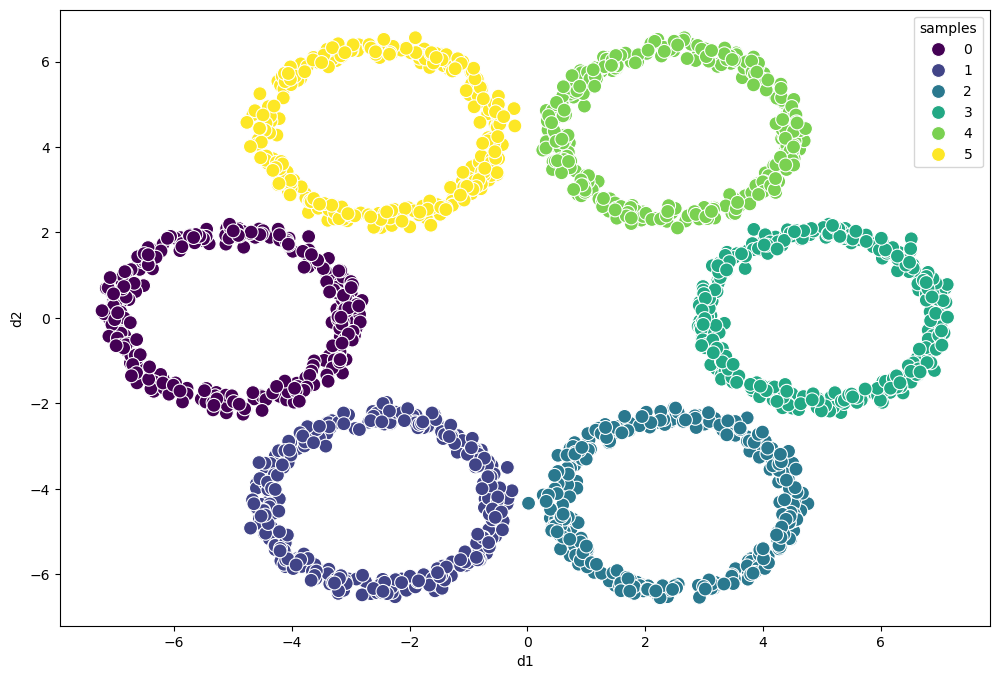

In [13]:
df = make_rings(
    2000, 6,
    data_scale = 5, 
    add_noise = True, noise_scale_theta = 0.7, 
    noise_scale_radius = 0.03,
    buffer = 0.8,
)
df.head()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, x='d1', y='d2', 
    hue='samples', palette='viridis', 
    size='samples', sizes=(100, 100), 
)

In [14]:
#| export
def make_jacks(
    n_axes = 3,
    points = 1000,
    label_by = 'axis',
    n_classes = 3,
    use_neg = True,
    data_scale = 3,
    add_noise = True,
    noise_scale = 0.03,
):

    _valid_label_bys = 'axis coord'.split()

    if label_by not in _valid_label_bys:
        label_by = _valid_label_bys[0]

    results = []
    classes = []

    axes = np.eye(n_axes)

    for i, axis in enumerate(axes):
        segment = np.linspace(0, 1, points // n_axes).reshape(-1, 1)
        if add_noise:
            coordinates = axis * (segment + np.random.randn(segment.size, 1) * noise_scale)
        else:
            coordinates = axis * segment
        results.extend(coordinates.tolist())

        if label_by == 'axis':
            labels = [i for j in range(len(segment))]
            classes.extend(labels)
        elif label_by == 'coord':
            labels = [
                k for k in range(n_classes)
                for j in range(points // n_axes // n_classes)
            ]
            for j in range(len(segment) - len(labels)):
                labels.append(n_classes - 1)
            classes.extend(labels)

    if use_neg:
        for i, axis in enumerate(axes):
            segment = np.linspace(0, 1, points // n_axes).reshape(-1, 1) * -1
            if add_noise:
                coordinates = axis * (segment + np.random.randn(segment.size, 1) * noise_scale)
            else:
                coordinates = axis * segment
            results.extend(coordinates.tolist())

            if label_by == 'axis':
                labels = [n_axes + i  for j in range(len(segment))]
                classes.extend(labels)
            elif label_by == 'coord':
                labels = [
                    k for k in range(n_classes)
                    for j in range(points // n_axes // n_classes)
                ]
                for j in range(len(segment) - len(labels)):
                    labels.append(n_classes - 1)
                classes.extend(labels)

    results = np.array(results) + np.random.randn(len(results), n_axes) * noise_scale
    results *= data_scale
    df = pd.DataFrame(results, columns=[f'd{i+1}' for i in range(n_axes)])
    df['samples'] = classes
    df.set_index('samples')
    return df

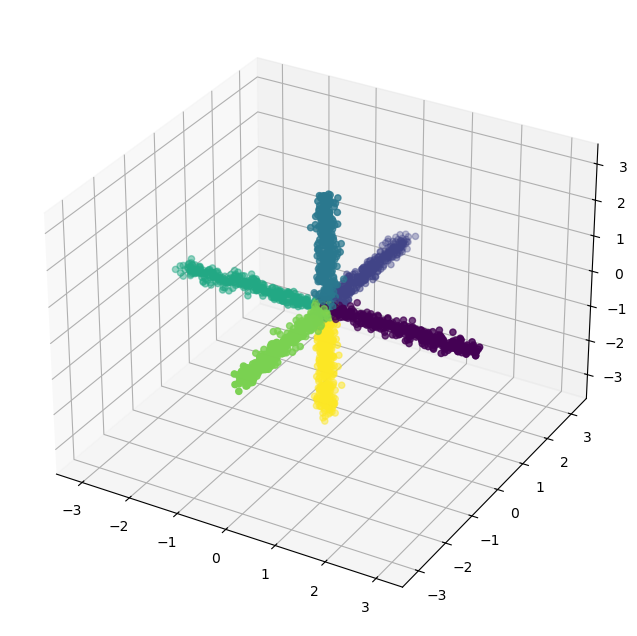

In [15]:
df = make_jacks(
    n_axes = 3,
    points = 1000,
    label_by = 'axis',
    n_classes = 3,
    use_neg = True,
    data_scale = 3,
    add_noise = True,
    noise_scale = 0.03,
)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter(df.d1, df.d2, df.d3, c=df.samples)

In [16]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

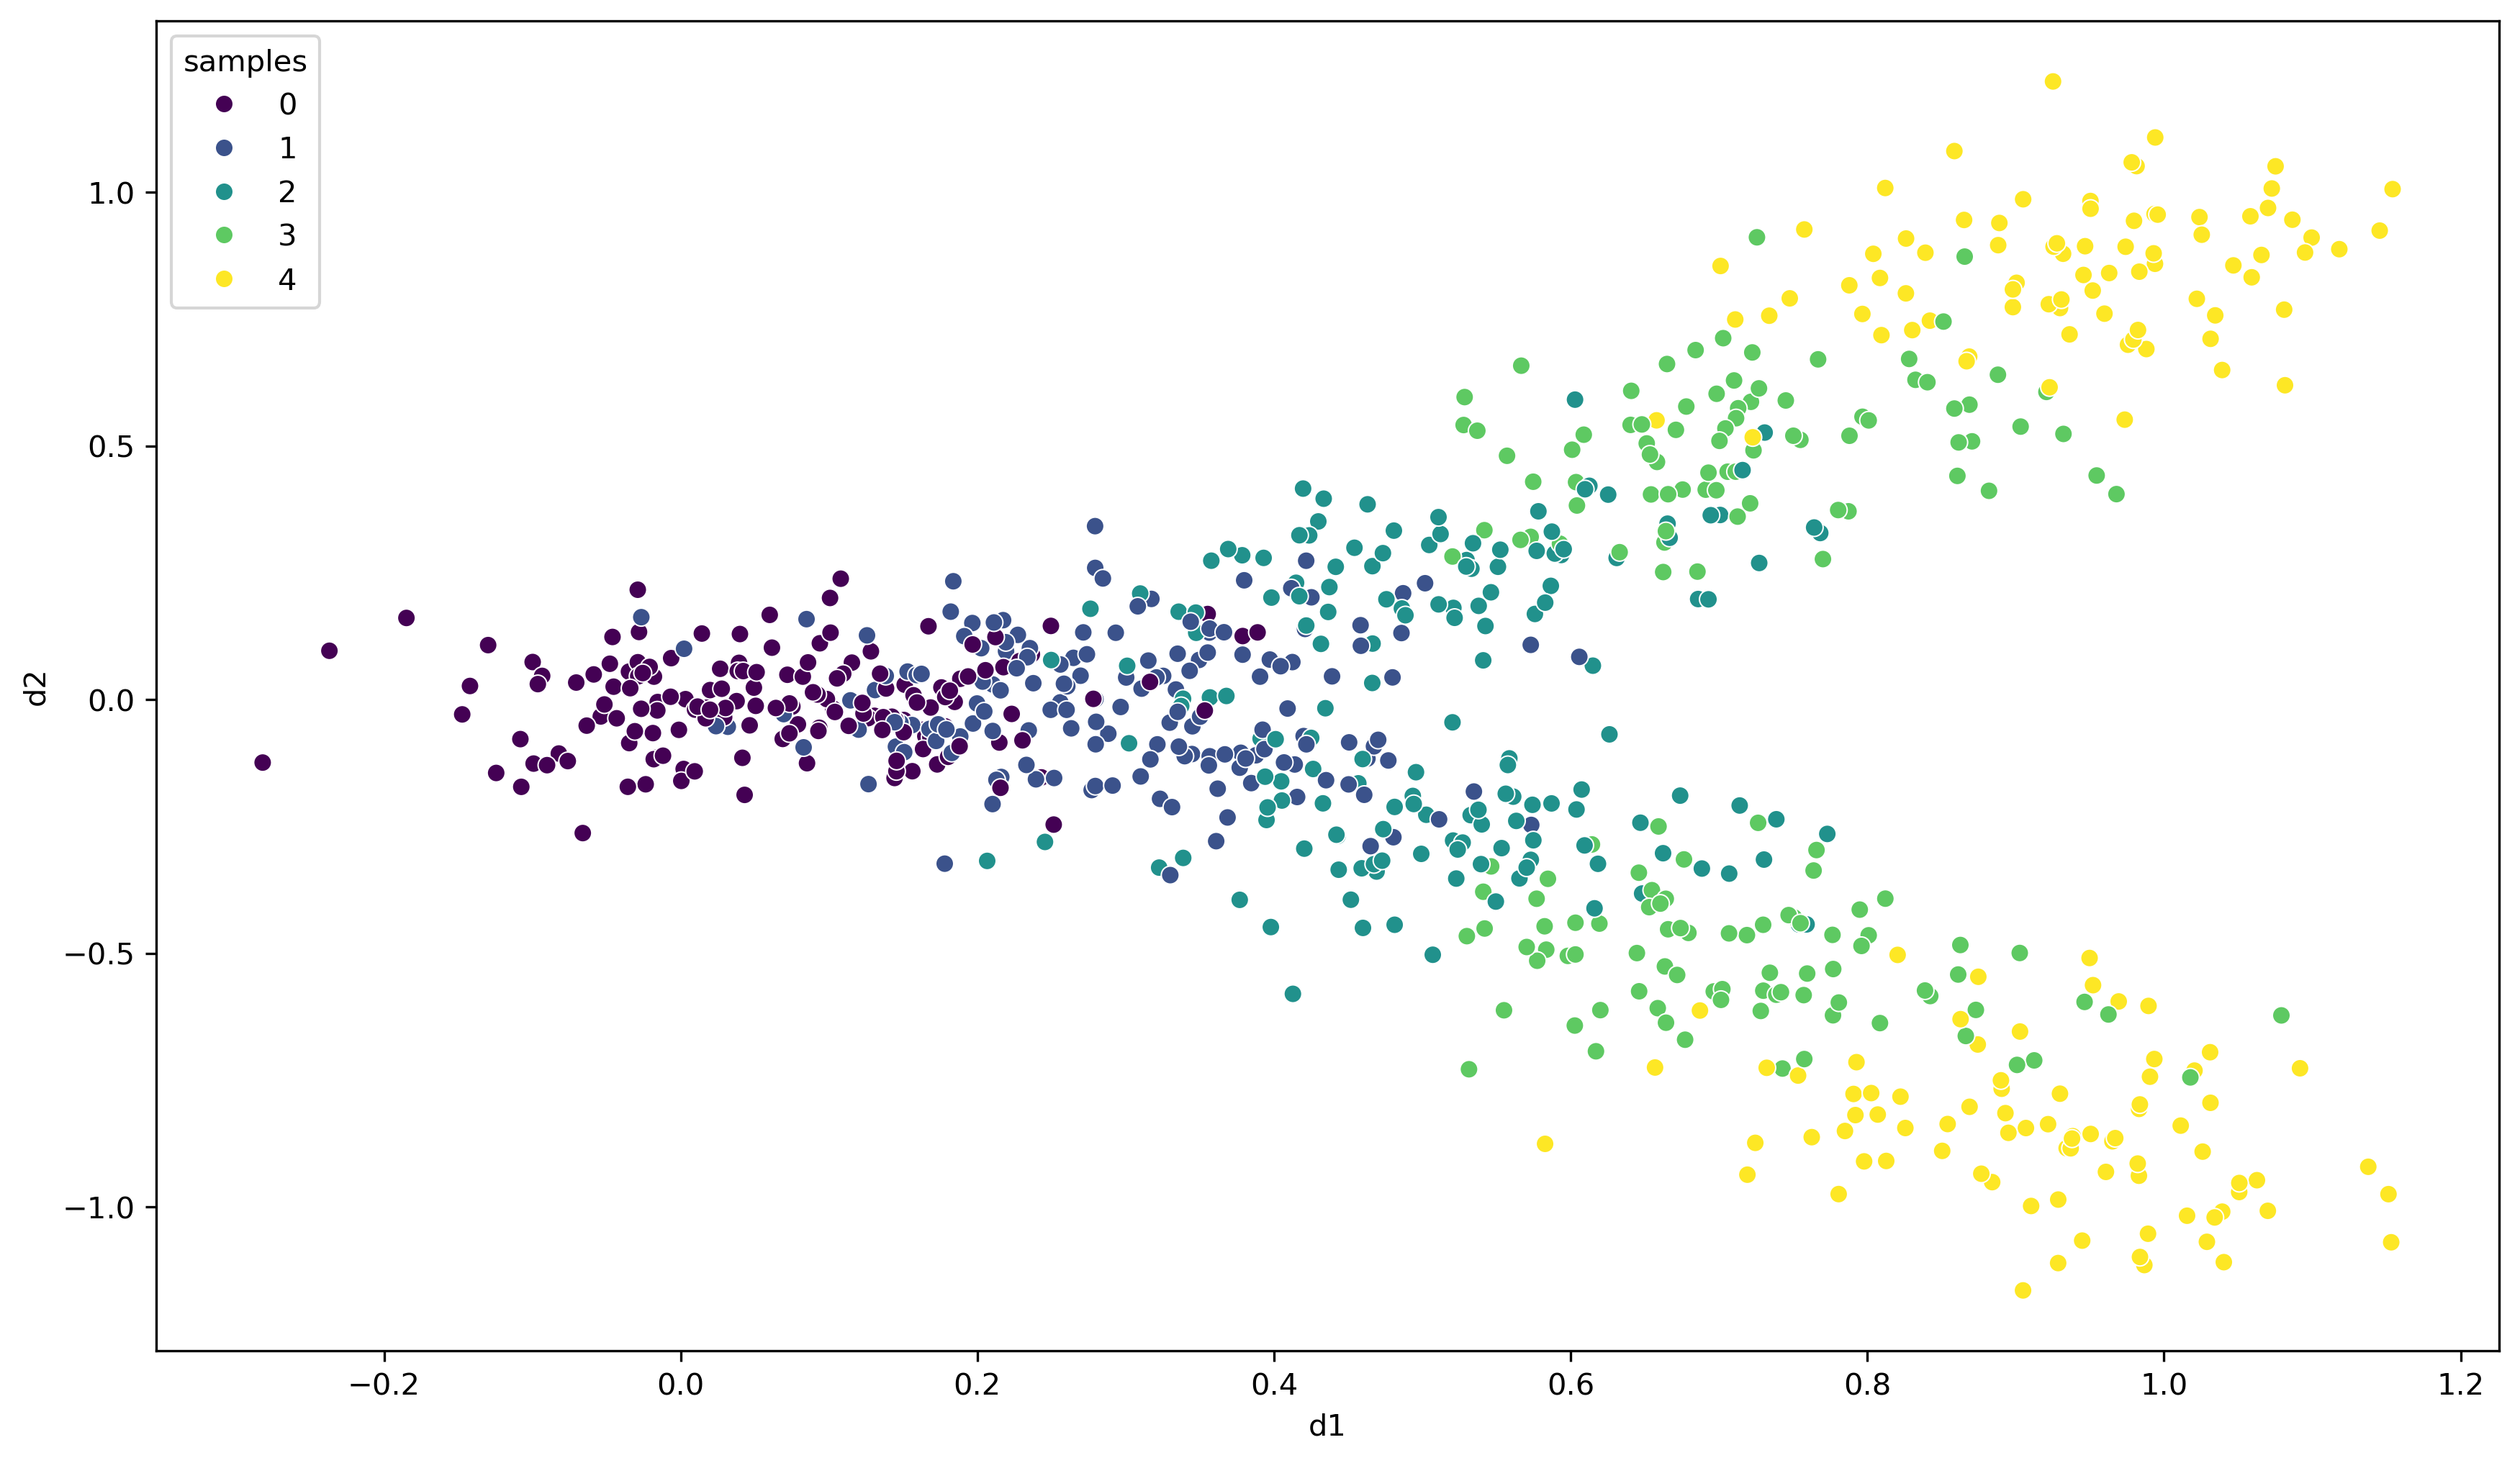

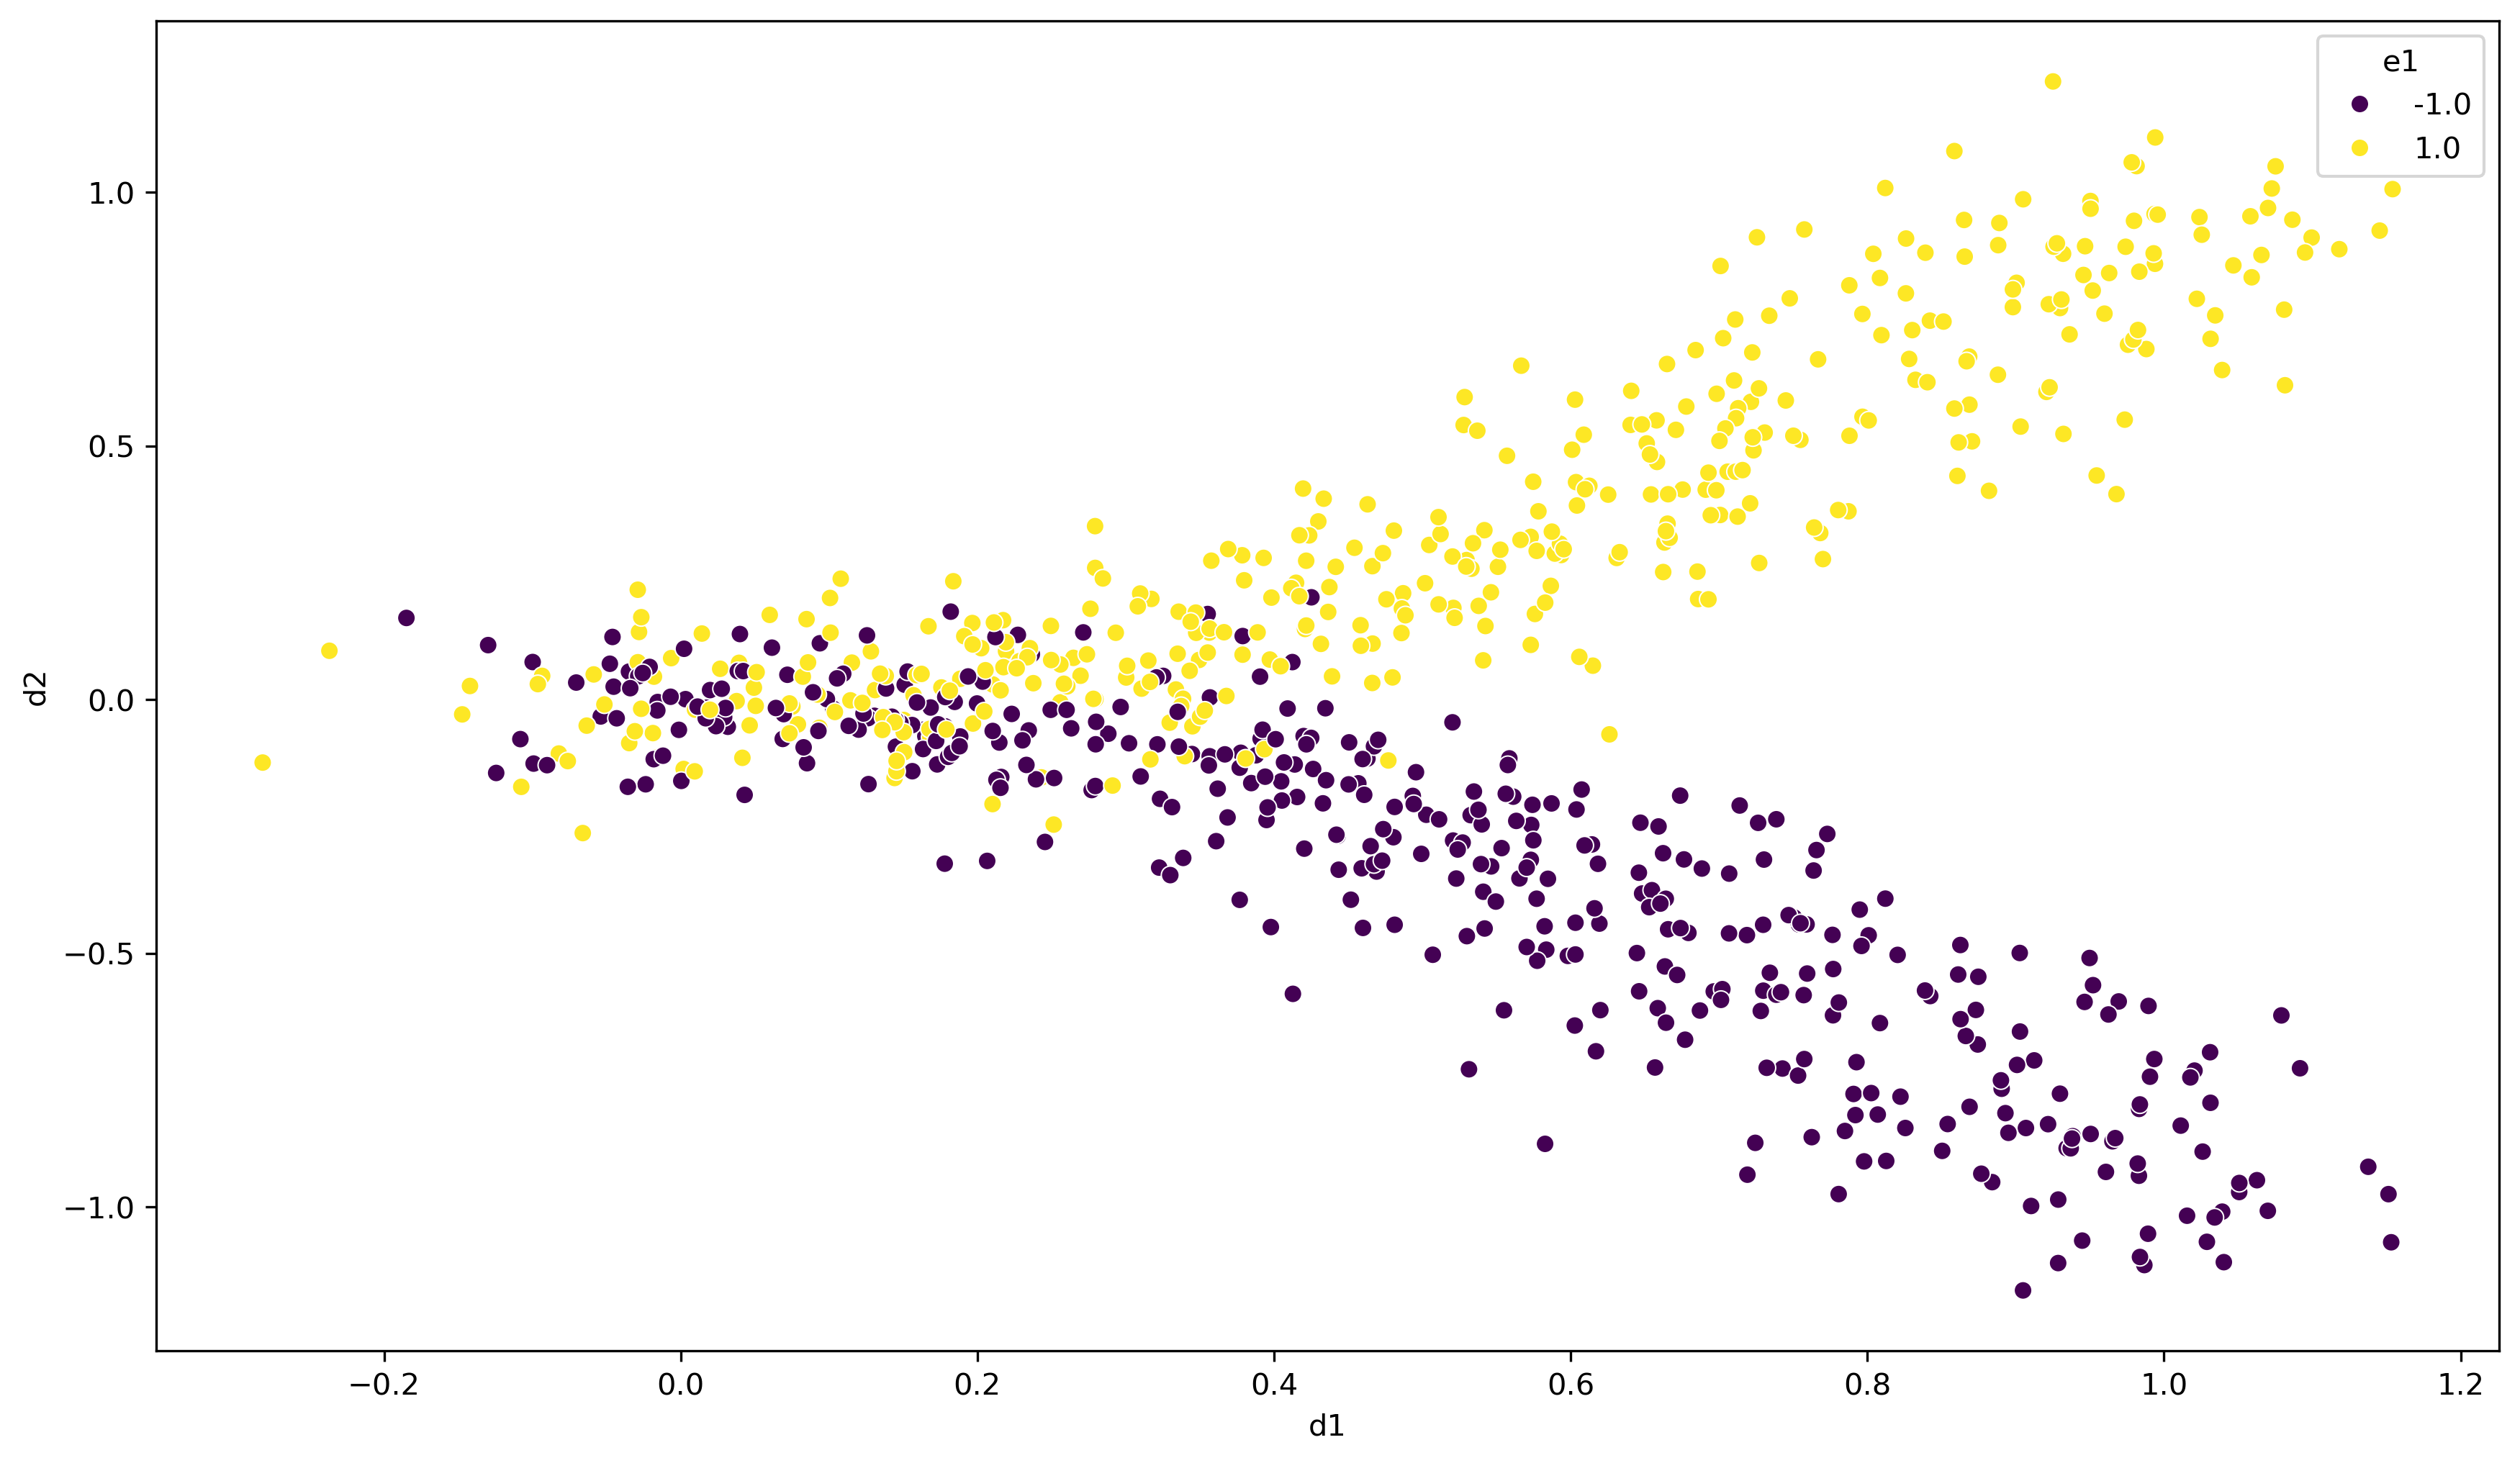

In [17]:
df = make_branch_cond(ne=2, repeats=20)
df = df[['samples', 'd1', 'd2', 'e1']]
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');
plt.show()
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');
plt.show()

In [18]:
#| export
def make_partial_branch(ne=2, noisex=0.05, noisey=.1, n_colors=5, repeats=20, drop_e=True):
    df = make_branch_cond(ne=ne, n_colors=n_colors, repeats=repeats, noisex=noisex, noisey=noisey)
    top_branch = (df['e1'] == 1) & (df['samples'].isin([2,3,4]))
    df.loc[top_branch, 'd2'] = (df[top_branch]['d2'] - df[top_branch]['d2'].mean())/3 + df[top_branch]['d2'].mean() - 0.2
    top_drop = np.random.choice(np.where(top_branch)[0], int(top_branch.sum()*2/3))
    df = df.drop(top_drop, axis=0)
    if drop_e:
        df.drop(columns=['e1'], inplace=True)
    return df

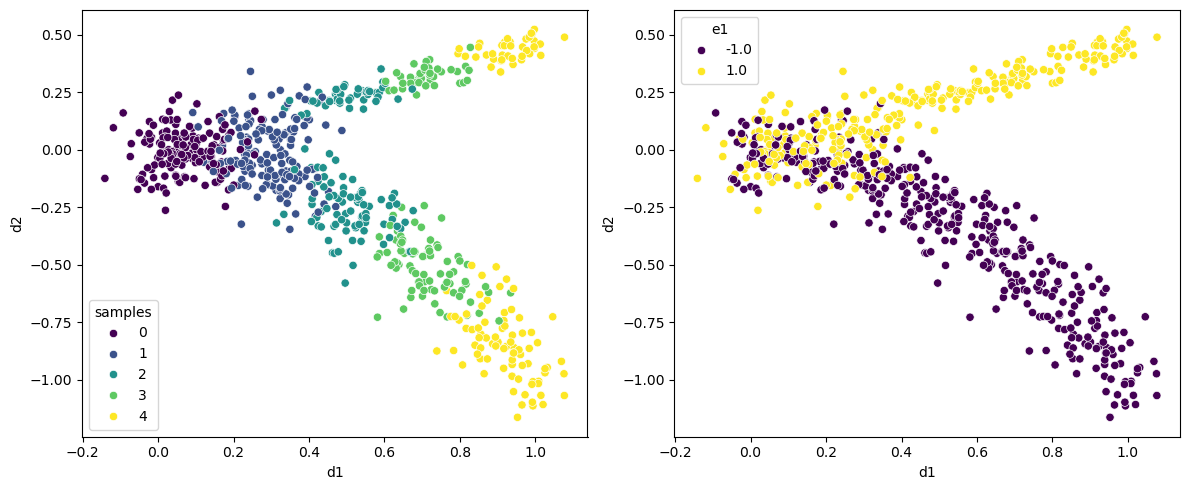

(685, 4)

In [19]:
df = make_partial_branch(noisex=0.05, noisey=0.1, drop_e=False)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis', ax=axs[0])
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis', ax=axs[1])
plt.tight_layout()
plt.show()
df.shape

In [20]:
#| export
import numpy as np
import pandas as pd

def make_uniform_rect(x_bounds, y_bounds, num_points):
    """
    Generates uniformly distributed points within a rectangular box.

    Parameters:
    - x_bounds: Tuple (x_min, x_max) defining the bounds on the X-axis.
    - y_bounds: Tuple (y_min, y_max) defining the bounds on the Y-axis.
    - num_points: The number of points to generate.

    Returns:
    - points: A 2D numpy array where each row is a point [x, y].
    """
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    
    x_points = np.random.uniform(x_min, x_max, num_points)
    y_points = np.random.uniform(y_min, y_max, num_points)

    points = np.column_stack((x_points, y_points))
    
    return points

import numpy as np
import pandas as pd

def make_gaussian_rect(x_bounds, y_bounds, num_points):
    """
    Generates Gaussian distributed points within a rectangular box.
    
    Parameters:
    - x_bounds: Tuple (x_min, x_max) defining the bounds on the X-axis.
    - y_bounds: Tuple (y_min, y_max) defining the bounds on the Y-axis.
    - num_points: The number of points to generate.
    
    Returns:
    - points: A 2D numpy array where each row is a point [x, y].
    """
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    
    # Calculate the mean and standard deviation based on the bounds
    x_mean = (x_min + x_max) / 2
    y_mean = (y_min + y_max) / 2
    x_std = (x_max - x_min) / 3  # 99.7% of data within bounds for ±3 std
    y_std = (y_max - y_min) / 6
    
    # Generate Gaussian distributed points within the rectangle
    x_points = np.random.normal(x_mean, x_std, num_points)
    y_points = np.random.normal(y_mean, y_std, num_points)
    
    # Clip the points to stay within the specified bounds
    x_points = np.clip(x_points, x_min, x_max)
    y_points = np.clip(y_points, y_min, y_max)
    
    # Combine the points into a 2D array (each row is a point [x, y])
    points = np.column_stack((x_points, y_points))
    
    return points

def make_dying_example_unif(n_pts_per_bin=50, seed=223):
    np.random.seed(seed)
    tp0 = make_uniform_rect((-1.5, -0.4), (-0.5, 0.5), n_pts_per_bin*2)
    tp1 = make_uniform_rect((-0.6, 0.6), (-0.5, 0.5), n_pts_per_bin*2)
    tp2 = make_uniform_rect((0.4, 1.6), (-0.5, 0.5), n_pts_per_bin*2)
    tp3 = make_uniform_rect((1.4, 2.6), (0., 0.5), n_pts_per_bin)
    tp4 = make_uniform_rect((2.4, 3.1), (0., 0.5), n_pts_per_bin)
    # concatenate, but add a column for the timepoint, make it a dataframe
    # Create dataframes and add a timepoint column

    df_tp0 = pd.DataFrame(tp0, columns=['d1', 'd2'])
    df_tp0['samples'] = 0

    df_tp1 = pd.DataFrame(tp1, columns=['d1', 'd2'])
    df_tp1['samples'] = 1

    df_tp2 = pd.DataFrame(tp2, columns=['d1', 'd2'])
    df_tp2['samples'] = 2

    df_tp3 = pd.DataFrame(tp3, columns=['d1', 'd2'])
    df_tp3['samples'] = 3

    df_tp4 = pd.DataFrame(tp4, columns=['d1', 'd2'])
    df_tp4['samples'] = 4

    # Concatenate the dataframes
    df = pd.concat([df_tp0, df_tp1, df_tp2, df_tp3, df_tp4], ignore_index=True)
    return df

def make_dying_example_gaus(n_pts_per_bin=50, seed=223):
    np.random.seed(seed)
    tp0 = make_gaussian_rect((-1.5, -0.4), (-0.5, 0.5), n_pts_per_bin*2)
    tp1 = make_gaussian_rect((-0.6, 0.6), (-0.5, 0.5), n_pts_per_bin*2)
    tp2 = make_gaussian_rect((0.4, 1.6), (-0.5, 0.5), n_pts_per_bin*2)
    tp3 = make_gaussian_rect((1.4, 2.6), (0., 0.5), n_pts_per_bin)
    tp4 = make_gaussian_rect((2.4, 3.1), (0., 0.5), n_pts_per_bin)
    # concatenate, but add a column for the timepoint, make it a dataframe
    # Create dataframes and add a timepoint column

    df_tp0 = pd.DataFrame(tp0, columns=['d1', 'd2'])
    df_tp0['samples'] = 0

    df_tp1 = pd.DataFrame(tp1, columns=['d1', 'd2'])
    df_tp1['samples'] = 1

    df_tp2 = pd.DataFrame(tp2, columns=['d1', 'd2'])
    df_tp2['samples'] = 2

    df_tp3 = pd.DataFrame(tp3, columns=['d1', 'd2'])
    df_tp3['samples'] = 3

    df_tp4 = pd.DataFrame(tp4, columns=['d1', 'd2'])
    df_tp4['samples'] = 4

    # Concatenate the dataframes
    df = pd.concat([df_tp0, df_tp1, df_tp2, df_tp3, df_tp4], ignore_index=True)
    return df


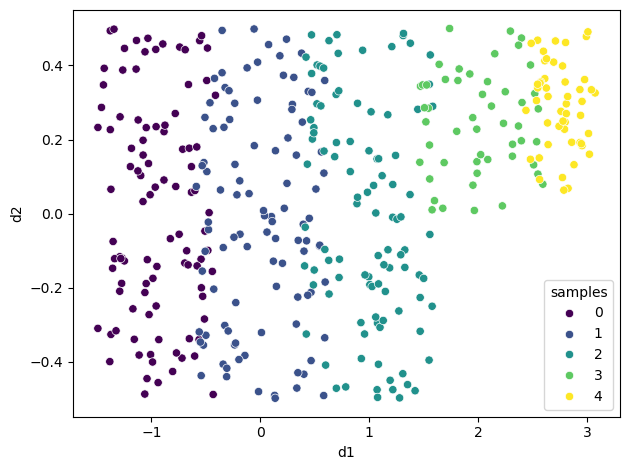

In [21]:
df = make_dying_example_unif()
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis', ax=ax)
plt.tight_layout()
plt.show()



In [22]:
#| export
import numpy as np
import pandas as pd

def make_growing(n_points_per_part=[50,100,150,200], noise_level=0.1, x_max=1):
    """
    Generates random points in the region between y=x^2, y=-x^2, and x=x_max, and adds noise to it.
    The points are split evenly into parts with numbers equal to len(n_points_per_part) by x.
    
    Parameters:
    n_points_per_part (list of int): List containing the number of points to generate in each part.
    noise_level (float): Standard deviation of the Gaussian noise to be added.
    x_max (float): The maximum range of x.
    
    Returns:
    pd.DataFrame: DataFrame containing the generated points with columns 'd1', 'd2', and 'samples'.
    """
    n_parts = len(n_points_per_part)
    x_ranges = [(i * x_max / n_parts, (i + 1) * x_max / n_parts) for i in range(n_parts)]
    
    points = []
    
    for i, n_points in enumerate(n_points_per_part):
        x = np.random.uniform(x_ranges[i][0], x_ranges[i][1], n_points)
        y = np.random.uniform(-x**2, x**2, n_points)
        noise_x = np.random.normal(0, noise_level, n_points)
        noise_y = np.random.normal(0, noise_level, n_points)
        part_points = np.vstack((x + noise_x, y + noise_y)).T
        samples = np.full(n_points, i)
        part_df = pd.DataFrame(part_points, columns=['d1', 'd2'])
        part_df['samples'] = samples
        points.append(part_df)
    
    return pd.concat(points, ignore_index=True)


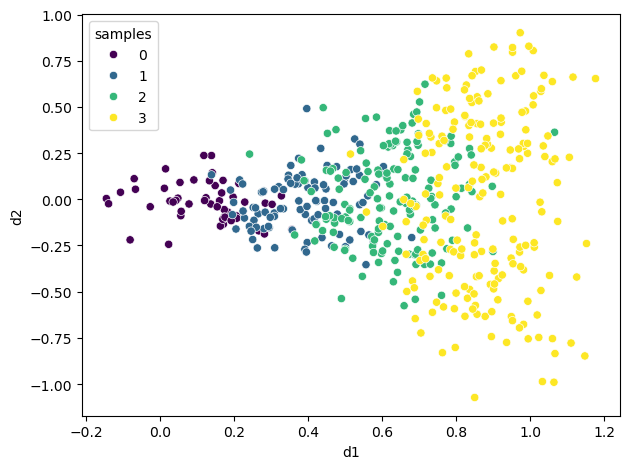

In [23]:
df = make_growing()
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis', ax=ax)
plt.tight_layout()
plt.show()
